# Install, import and settings

In [1]:
!pip install category_encoders pycaret --quiet

这里用PyCaret的Bank数据集做演示：随机抽取100组不同的特征子集，每组特征分别训练4种模型（Logistic Regression、Decision Tree、Random Forest、LightGBM），得到400个候选模型。所有指标都在独立的测试集上计算。

In [2]:
from category_encoders import CatBoostEncoder
from lightgbm import LGBMClassifier
from pycaret.datasets import get_data
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, brier_score_loss, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
pd.set_option("display.max_colwidth", None)
plt.rc('axes', axisbelow=True)

# Utils

In [4]:
def get_dataset(dataset_name, target_name):
    """Get dataset."""
    df = get_data(dataset_name, verbose=False)
    X, y = df.drop(target_name, axis=1), df[target_name]
    y = y.replace({yval: binval for yval, binval in zip(y.value_counts().index, [0,1])})
    num_features = X.columns[X.apply(is_numeric)].tolist()
    cat_features = [c for c in X.columns if c not in num_features]
    X = X.fillna({f: "NA" for f in cat_features})
    return X, y, num_features, cat_features


def is_numeric(x):
    """Check whether an object is numeric."""
    try:
        x+0
        return True
    except:
        return False


def expected_calibration_error(y_true, y_proba, bins=10):
    bin_count, bin_edges = np.histogram(y_proba, bins=bins)
    n_bins = len(bin_count)
    bin_edges[-1] += 1e-8
    bin_id = np.digitize(y_proba, bin_edges, right=False) - 1
    bin_ysum = np.bincount(bin_id, weights=y_true, minlength=n_bins)
    bin_probasum = np.bincount(bin_id, weights=y_proba, minlength=n_bins)
    bin_ymean = np.divide(bin_ysum, bin_count, out=np.zeros(n_bins), where=bin_count > 0)
    bin_probamean = np.divide(bin_probasum, bin_count, out=np.zeros(n_bins), where=bin_count > 0)
    ece = np.abs((bin_probamean-bin_ymean) * bin_count).sum() / len(y_proba)
    return ece


def mean_absolute_deviation(x):
    x = np.array(x)
    return np.abs(x - x.mean()).mean()

# Read data

In [5]:
X, y, num_features, cat_features = get_dataset(dataset_name="bank", target_name="deposit")
features = num_features + cat_features
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=.5, random_state=123)

# Run models

In [22]:
%%time

probas = pd.DataFrame(index=y_tst.index)
results = pd.DataFrame(dtype=float, columns=["model", "features"])
enum = 0

while True:

    selected_features = np.random.choice(features, np.random.randint(1, len(features)-1), replace=False)
    selected_num_features = [f for f in num_features if f in selected_features]
    selected_cat_features = [f for f in cat_features if f in selected_features]

    if (results["features"] == ", ".join(sorted(selected_features))).any():
        continue

    for model_name, model in {
        "logistic_regression": Pipeline([
            ("encoder", CatBoostEncoder(cols=selected_cat_features)),
            ("predictor", LogisticRegression())]),
        "decision_tree": Pipeline([
            ("encoder", CatBoostEncoder(cols=selected_cat_features)),
            ("predictor", DecisionTreeClassifier(max_depth=5))]),
        "random_forest": Pipeline([
            ("encoder", CatBoostEncoder(cols=selected_cat_features)),
            ("predictor", RandomForestClassifier())]),
        "lightgbm": Pipeline([
            ("encoder", CatBoostEncoder(cols=selected_cat_features)),
            ("predictor", LGBMClassifier(verbose=-1))]),
    }.items():

        model = model.fit(X_trn[selected_features], y_trn)
        probas.loc[:, enum] = model.predict_proba(X_tst[selected_features])[:,1]

        results.loc[enum, "model"] = model_name
        results.loc[enum, "features"] = ", ".join(sorted(selected_features))
        results.loc[enum, "n_features"] = len(selected_features)
        results.loc[enum, "roc"] = roc_auc_score(y_tst, probas[enum])
        results.loc[enum, "logloss"] = log_loss(y_tst, probas[enum])
        results.loc[enum, "brier"] = brier_score_loss(y_tst, probas[enum])
        results.loc[enum, "ece"] = expected_calibration_error(y_tst, probas[enum], bins=20)
        results.loc[enum, "pmad"] = mean_absolute_deviation(probas[enum])
        results.loc[enum, "ece_over_pmad"] = results.loc[enum, "ece"] / results.loc[enum, "pmad"]

        enum += 1

    if enum == 100 * 4:
        break

results["roc_rank"] = results["roc"].rank(ascending=False)
results["logloss_rank"] = results["logloss"].rank()
results["brier_rank"] = results["brier"].rank()
results["ece_rank"] = results["ece"].rank()
results["ece_over_pmad_rank"] = results["ece_over_pmad"].rank()

CPU times: user 10min 39s, sys: 19.3 s, total: 10min 58s
Wall time: 10min 45s


# Write results

In [7]:
results.to_csv("/content/drive/MyDrive/Datasets/results.tsv", sep="\t", index=False)
y_tst.to_csv("/content/drive/MyDrive/Datasets/y_tst.tsv", sep="\t")
pd.DataFrame(probas).to_csv(f"/content/drive/MyDrive/Datasets/probas.tsv", sep="\t")

# Load results (for reproducibility)

In [8]:
results = pd.read_csv("/content/drive/MyDrive/Datasets/results.tsv", sep="\t")
y_tst = pd.read_csv("/content/drive/MyDrive/Datasets/y_tst.tsv", sep="\t", index_col=0).iloc[:,0]
probas = pd.read_csv(f"/content/drive/MyDrive/Datasets/probas.tsv", sep="\t", index_col=0).rename(lambda col: int(col), axis=1)

# Compute Pareto Frontier

In [9]:
frontier = pd.DataFrame()
max_pmad = -np.inf

for _, row in results.sort_values("pmad").groupby("ece").apply(lambda d: d.reset_index().iloc[-1]).set_index("index").iterrows():
    if row["pmad"] > max_pmad:
        frontier = pd.concat([frontier, row.to_frame().T])
        max_pmad = row["pmad"]

# Plots

In [10]:
def plot_base(ax):
    ax.scatter(results["pmad"], results["ece"], color="lightgrey", label="Models")
    ax.set_ylabel("ECE")
    ax.set_xlabel("pMAD")
    ax.set_ylim(-.001, .016)
    ax.set_xlim(-.01, .25)
    ax.set_yticklabels([f"{y:.1%}" for y in ax.get_yticks()])
    ax.set_xticklabels([f"{x:.0%}" for x in ax.get_xticks()])
    return ax

def plot_frontier(ax):
    for i in range(len(frontier)-1):
        ax.plot([frontier.iloc[i]["pmad"]]*2, frontier.iloc[[i,i+1]]["ece"], color="black", lw=2)
        ax.plot(frontier.iloc[[i,i+1]]["pmad"], [frontier.iloc[i+1]["ece"]]*2, color="black", lw=2)
    return ax

In [12]:
model_short_description = {
    results["roc"].idxmax(): "Best ROC",
    results["ece_over_pmad"].idxmin(): "Best ECE/pMAD Ratio",
    results["brier"].idxmin(): "Best Brier and Logloss",
    results["ece"].idxmin(): "Best ECE",
    results["ece"].nsmallest(2).index[1]: "Second best ECE",
    results[results["ece"] > .03].sort_values("ece").index[0]: "Bad ECE",
    frontier.index[-1]: "Last on frontier",
}

reverse_model_short_description = {v: k for k, v in model_short_description.items()}

model_color = {
    id: color for id, color in zip(model_short_description.keys(), plt.rcParams["axes.prop_cycle"].by_key()["color"])
}

model_long_description = {}

for id, short_description in model_short_description.items():
    part_1 = (f"**{short_description}**\n{results.loc[id,'model']} - {int(results.loc[id,'n_features'])} features"
        .replace("decision_tree", "DecisionTree")
        .replace("lightgbm", "LightGBM")
        .replace("random_forest", "RandomForest")
        .replace("1 features", "1 feature")
    )
    model_roc = f"{results.loc[id,'roc']:.1%}"
    model_brier = f"{results.loc[id,'brier']:.2%}"
    model_long_description[id] = f"{part_1}\n{{ROC: {model_roc}, Brier: {model_brier}}}"

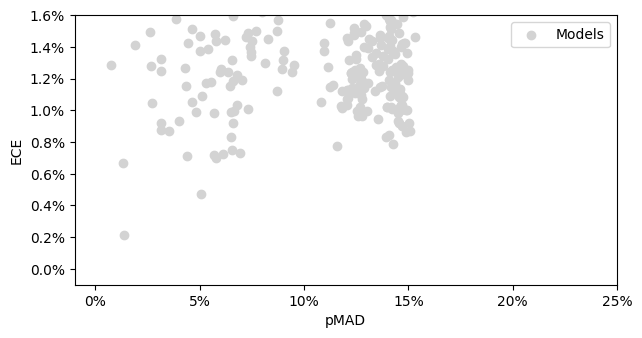

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax = plot_base(ax)
ax.legend()

fig.savefig(fname="scatter_01.png", dpi=200, bbox_inches="tight")

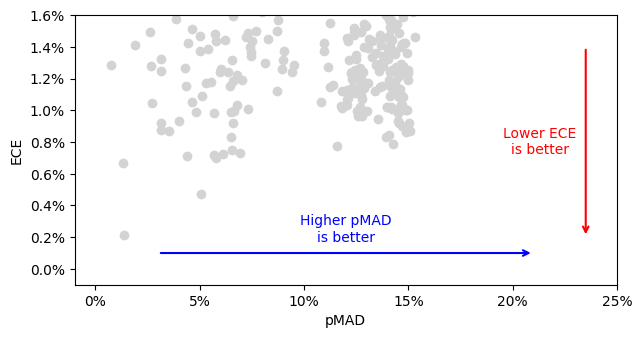

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax = plot_base(ax)

x, y_top, y_bottom = .235, .014, .002
ax.annotate(
    "",
    xy=(x, y_bottom), xytext=(x,y_top),
    arrowprops=dict(arrowstyle="->", color="red", lw=1.5)
)
ax.text(
    x-.022, (y_top + y_bottom)/2,
    "Lower ECE\nis better",
    va="center", ha="center",
    fontsize=10, color="red"
)

x_start, x_end, y = .03, .21, .001
plt.annotate(
    "",
    xy=(x_end, y), xytext=(x_start, y),
    arrowprops=dict(arrowstyle='->', color='blue', lw=1.5)
)
plt.text(
    (x_start + x_end)/2, y + 0.0015,
    'Higher pMAD\nis better',
    ha='center', va='center',
    fontsize=10, color='blue'
)

fig.savefig(fname="scatter_02.png", dpi=200, bbox_inches="tight")

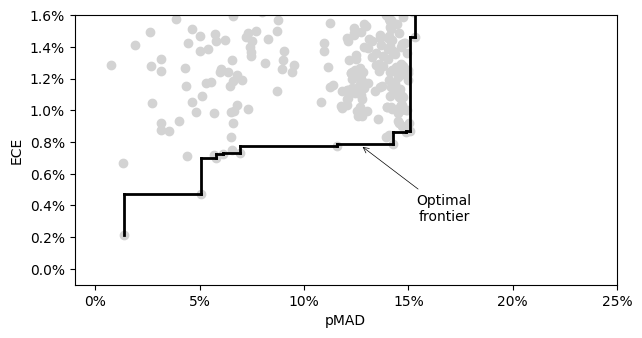

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax = plot_base(ax)
ax = plot_frontier(ax)

ax.annotate(
    text="Optimal\nfrontier",
    xy=(.127,.0078),
    xytext=(.127 + 0.04, .0078 - 0.004),
    arrowprops=dict(arrowstyle="->", linewidth=.5),
    ha="center", va="center", zorder=11)

fig.savefig(fname="scatter_03.png", dpi=200, bbox_inches="tight")

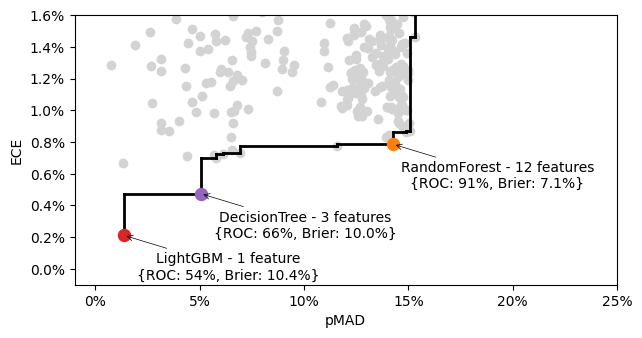

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax = plot_base(ax)
ax = plot_frontier(ax)

for sd in ["Best ECE", "Second best ECE", "Best ECE/pMAD Ratio"]:
    id = reverse_model_short_description[sd]
    model_alias = (f"{results.loc[id,'model']} - {int(results.loc[id,'n_features'])} features"
        .replace("decision_tree", "DecisionTree")
        .replace("lightgbm", "LightGBM")
        .replace("random_forest", "RandomForest")
        .replace("1 features", "1 feature")
    )
    model_roc = f"{results.loc[id,'roc']:.0%}"
    model_brier = f"{results.loc[id,'brier']:.1%}"
    text = f"{model_alias}\n{{ROC: {model_roc}, Brier: {model_brier}}}"
    ax.scatter(results.loc[id,"pmad"], results.loc[id,"ece"], zorder=10, s=75, color=model_color[id])
    ax.annotate(
        text=text,
        xy=results.loc[id,["pmad", "ece"]],
        xytext=(results.loc[id,"pmad"] + 0.05, results.loc[id,"ece"] - 0.002),
        arrowprops=dict(arrowstyle="->", linewidth=.5),
        ha="center", va="center", zorder=11)

fig.savefig(fname="scatter_04.png", dpi=200, bbox_inches="tight")

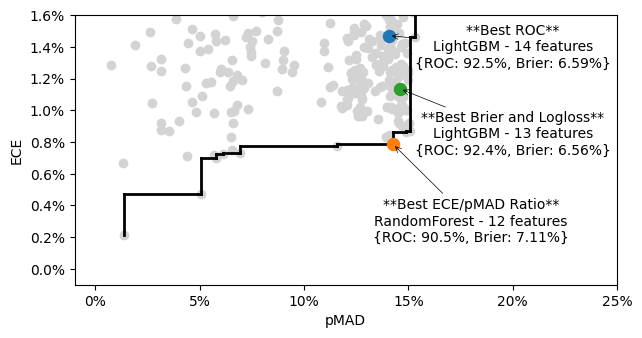

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3.5))
ax = plot_base(ax)
ax = plot_frontier(ax)

xytext = {
    reverse_model_short_description["Best ROC"]: [.20, .014],
    reverse_model_short_description["Best Brier and Logloss"]: [.20, .0085],
    reverse_model_short_description["Best ECE/pMAD Ratio"]: [.18, .003],
}

for id in xytext.keys():
    ax.scatter(results.loc[id,"pmad"], results.loc[id,"ece"], zorder=10, s=75, color=model_color[id])
    ax.annotate(
        text=model_long_description[id],
        xy=results.loc[id,["pmad", "ece"]],
        xytext=xytext[id],
        arrowprops=dict(arrowstyle="->", linewidth=.5),
        ha="center", va="center", zorder=11)

fig.savefig(fname="scatter_05.png", dpi=200, bbox_inches="tight")

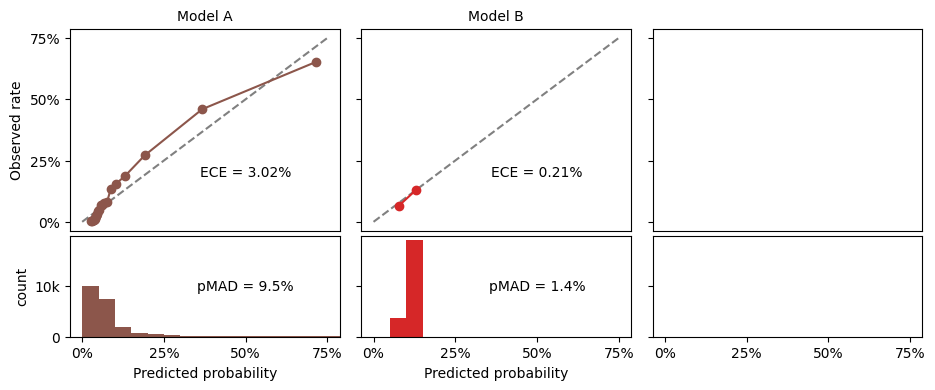

In [18]:
fig, axs = plt.subplots(2, 3, figsize=(11, 4), gridspec_kw={"height_ratios": [2, 1]}, sharey="row", sharex="row")
plt.subplots_adjust(wspace=.08, hspace=.03)

hist_bins = np.linspace(0, 1, 21)

ids = [reverse_model_short_description[sd] for sd in ["Bad ECE", "Best ECE"]]
titles = ["Model A", "Model B"]

for enum, id in enumerate(ids):
    y_means, proba_means = calibration_curve(y_true=y_tst, y_prob=probas[id], n_bins=20, strategy="quantile")
    axs[0,enum].plot([0,.75],[0,.75], ls="--", color="grey",zorder=1)
    axs[0,enum].scatter(proba_means, y_means, color=model_color[id])
    axs[0,enum].plot(proba_means, y_means, color=model_color[id])
    axs[0,enum].set_title(titles[enum], fontsize=10)
    axs[0,enum].text(s=f"ECE = {results.loc[id,'ece']:.2%}", x=.5, y=.2, ha="center", va="center")
    axs[1,enum].hist(probas[id], bins=hist_bins, color=model_color[id])
    axs[1,enum].text(s=f"pMAD = {results.loc[id,'pmad']:.1%}", x=.5, y=10_000, ha="center", va="center")
    axs[1,enum].set_xlabel("Predicted probability")

axs[0,0].set_yticks([0, .25, .5, .75])
axs[0,0].set_yticklabels(["0%", "25%", "50%", "75%"])
axs[0,0].set_ylabel("Observed rate")
axs[0,0].set_xticks([])
axs[0,0].set_xlim([-0.0375, 0.7875])

axs[1,0].set_yticks([0, 10_000])
axs[1,0].set_yticklabels(["0", "10k"])
axs[1,0].set_xticks([0, .25, .5, .75])
axs[1,0].set_xticklabels(["0%", "25%", "50%", "75%"])
axs[1,0].set_ylabel("count")
axs[1,0].set_xlim([-0.0375, 0.7875])

fig.savefig(fname="caliplot_01.png", dpi=200, bbox_inches="tight")

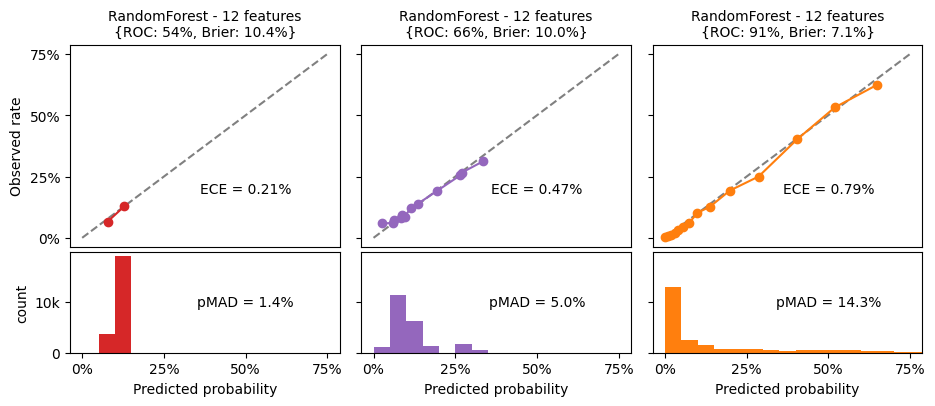

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(11, 4), gridspec_kw={"height_ratios": [2, 1]}, sharey="row", sharex="row")
plt.subplots_adjust(wspace=.08, hspace=.03)

hist_bins = np.linspace(0, 1, 21)

ids = [reverse_model_short_description[sd] for sd in ["Best ECE", "Second best ECE", "Best ECE/pMAD Ratio"]]

for enum, id in enumerate(ids):
    model_roc = f"{results.loc[id,'roc']:.0%}"
    model_brier = f"{results.loc[id,'brier']:.1%}"
    title = f"{model_alias}\n{{ROC: {model_roc}, Brier: {model_brier}}}"
    y_means, proba_means = calibration_curve(y_true=y_tst, y_prob=probas[id], n_bins=20, strategy="quantile")
    axs[0,enum].plot([0,.75],[0,.75], ls="--", color="grey",zorder=1)
    axs[0,enum].scatter(proba_means, y_means, color=model_color[id])
    axs[0,enum].plot(proba_means, y_means, color=model_color[id])
    axs[0,enum].set_title(title, fontsize=10)
    axs[0,enum].text(s=f"ECE = {results.loc[id,'ece']:.2%}", x=.5, y=.2, ha="center", va="center")
    axs[1,enum].hist(probas[id], bins=hist_bins, color=model_color[id])
    axs[1,enum].text(s=f"pMAD = {results.loc[id,'pmad']:.1%}", x=.5, y=10_000, ha="center", va="center")
    axs[1,enum].set_xlabel("Predicted probability")

axs[0,0].set_yticks([0, .25, .5, .75])
axs[0,0].set_yticklabels(["0%", "25%", "50%", "75%"])
axs[0,0].set_ylabel("Observed rate")
axs[0,0].set_xticks([])
axs[0,0].set_xlim([-0.0375, 0.7875])

axs[1,0].set_yticks([0, 10_000])
axs[1,0].set_yticklabels(["0", "10k"])
axs[1,0].set_xticks([0, .25, .5, .75])
axs[1,0].set_xticklabels(["0%", "25%", "50%", "75%"])
axs[1,0].set_ylabel("count")
axs[1,0].set_xlim([-0.0375, 0.7875])

fig.savefig(fname="caliplot_02.png", dpi=200, bbox_inches="tight")

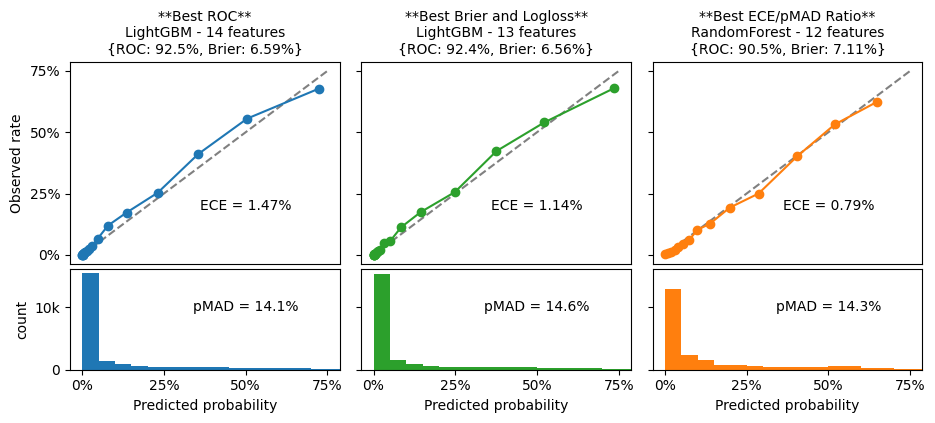

In [20]:
fig, axs = plt.subplots(2, 3, figsize=(11, 4), gridspec_kw={"height_ratios": [2, 1]}, sharey="row", sharex="row")
plt.subplots_adjust(wspace=.08, hspace=.03)

hist_bins = np.linspace(0, 1, 21)

ids = [reverse_model_short_description[sd] for sd in ["Best ROC", "Best Brier and Logloss", "Best ECE/pMAD Ratio"]]

for enum, id in enumerate(ids):
    y_means, proba_means = calibration_curve(y_true=y_tst, y_prob=probas[id], n_bins=20, strategy="quantile")
    axs[0,enum].plot([0,.75],[0,.75], ls="--", color="grey",zorder=1)
    axs[0,enum].scatter(proba_means, y_means, color=model_color[id])
    axs[0,enum].plot(proba_means, y_means, color=model_color[id])
    axs[0,enum].set_title(model_long_description[id], fontsize=10)
    axs[0,enum].text(s=f"ECE = {results.loc[id,'ece']:.2%}", x=.5, y=.2, ha="center", va="center")
    axs[1,enum].hist(probas[id], bins=hist_bins, color=model_color[id])
    axs[1,enum].text(s=f"pMAD = {results.loc[id,'pmad']:.1%}", x=.5, y=10_000, ha="center", va="center")
    axs[1,enum].set_xlabel("Predicted probability")

axs[0,0].set_yticks([0, .25, .5, .75])
axs[0,0].set_yticklabels(["0%", "25%", "50%", "75%"])
axs[0,0].set_ylabel("Observed rate")
axs[0,0].set_xticks([])
axs[0,0].set_xlim([-0.0375, 0.7875])

axs[1,0].set_yticks([0, 10_000])
axs[1,0].set_yticklabels(["0", "10k"])
axs[1,0].set_xticks([0, .25, .5, .75])
axs[1,0].set_xticklabels(["0%", "25%", "50%", "75%"])
axs[1,0].set_ylabel("count")
axs[1,0].set_xlim([-0.0375, 0.7875])

fig.savefig(fname="caliplot_03.png", dpi=200, bbox_inches="tight")